<a href="https://colab.research.google.com/github/OverfitSurvivor/code/blob/main/drone_DAE_MSSSIM_L1_good_0425_ramp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [25]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 5.6 MB/s eta 0:00:00


In [51]:
!pip install torchinfo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import zipfile

zip_path = "/content/drive/MyDrive/ICSV31AIChallengeDataset.zip"  # 업로드한 ZIP 파일 경로
extract_path = "/content/ICSV31AIChallengeDataset"  # 압축을 풀 폴더 경로

# 폴더가 없으면 생성
os.makedirs(extract_path, exist_ok=True)

# 압축 해제
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료:", extract_path)

압축 해제 완료: /content/ICSV31AIChallengeDataset


## 모듈 불러오기

In [4]:
import csv
import argparse
import os
from typing import Any, List, Tuple

import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 라벨링 및 데이터셋 로더
+ global scaling STFT 적용

In [5]:
#######################
# 1. Utils
#######################
def read_csv(file_path: str) -> List:
    with open(file_path, "r") as f:
        reader = csv.reader(f)
        return list(reader)

def save_csv(save_data: List[Any], save_file_path: str) -> None:
    with open(save_file_path, "w", newline="") as f:
        writer = csv.writer(f, lineterminator="\n")
        writer.writerows(save_data)

def get_anomaly_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    train_mode = file_name.split("_")[0]
    if train_mode == "test":
        return -1
    elif "normal" in file_name:
        return 0
    else:
        return 1

def get_drone_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    drone_mode = file_name.split("_")[1]
    if drone_mode == "A":
        return 0
    elif drone_mode == "B":
        return 1
    elif drone_mode == "C":
        return 2
    else:
        return -1

def get_direction_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    direction_mode = file_name.split("_")[2]
    if direction_mode == "Back":
        return 0
    elif direction_mode == "Front":
        return 1
    elif direction_mode == "Left":
        return 2
    elif direction_mode == "Right":
        return 3
    elif direction_mode == "Clockwise":
        return 4
    elif direction_mode == "CounterClockwise":
        return 5
    else:
        return -1

Global Mean: -4.636630590752749
Global Std: 12.173359870910645

Global Mean: -4.616434057646901
Global Std: 12.162795066833496


In [6]:
#######################
# 2. Feature Extraction & Augmentation
#######################
# 계산된 전역 평균과 표준편차
# STFT 바꿀때마다 계산해줘야함

GLOBAL_MEAN = -4.616434057646901
GLOBAL_STD = 12.162795066833496
def wav_to_log_stft(
    wav_path: str,
    sr: int,
    n_fft: int,
    win_length: int,
    hop_length: int,
    power: float,
) -> torch.Tensor:
    """
    WAV 파일을 STFT 기반 로그 스펙트럼으로 변환.
    - torchaudio.transforms.Spectrogram로 STFT 계산
    - AmplitudeToDB로 로그 변환 후 global standard scaling 적용 **
    """
    stft_transform = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=power
    )
    wav_data, _ = torchaudio.load(wav_path)
    spec = stft_transform(wav_data)
    amp_to_db = torchaudio.transforms.AmplitudeToDB()
    log_spec = amp_to_db(spec)

    # 전체 데이터셋의 평균과 표준편차로 정규화 적용
    log_spec = (log_spec - GLOBAL_MEAN) / (GLOBAL_STD + 1e-9)
    return log_spec


def augment_spec(spec: torch.Tensor) -> torch.Tensor:
    max_shift = int(spec.shape[-1] * 0.1)
    shift = torch.randint(-max_shift, max_shift + 1, (1,)).item()
    spec = torch.roll(spec, shifts=shift, dims=-1)
    time_mask_param = max(1, int(spec.shape[-1] * 0.05))
    time_mask = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
    spec = time_mask(spec)
    freq_mask_param = max(1, int(spec.shape[-2] * 0.05))
    freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
    spec = freq_mask(spec)
    return spec

#######################
# 3. Dataset
#######################
class BaselineDataLoader(Dataset):
    def __init__(
        self,
        file_list: List[str],
        sr: int,
        n_fft: int,
        win_length: int,
        hop_length: int,
        power: float,
        augment: bool = False
    ) -> None:
        self.file_list = file_list
        self.sr = sr
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.power = power
        self.augment = augment

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, int, int]:
        wav_path = self.file_list[idx]
        spec = wav_to_log_stft(wav_path, self.sr, self.n_fft, self.win_length, self.hop_length, self.power)
        if self.augment:
            spec = augment_spec(spec)
        anomaly_label = get_anomaly_label(wav_path)
        drone_label = get_drone_label(wav_path)
        direction_label = get_direction_label(wav_path)
        return spec, anomaly_label, drone_label, direction_label

from typing import Tuple, List
from torch.utils.data import DataLoader

## 모델 학습 및 평가

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GMSDLoss(nn.Module):
    def __init__(self, T: float = 0.0026):
        super(GMSDLoss, self).__init__()
        weight_x = torch.tensor([[-1, 0, 1],
                                 [-2, 0, 2],
                                 [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3)
        weight_y = torch.tensor([[-1, -2, -1],
                                 [0,  0,  0],
                                 [1,  2,  1]], dtype=torch.float32).view(1, 1, 3, 3)
        self.register_buffer('weight_x', weight_x)
        self.register_buffer('weight_y', weight_y)
        self.T = T

    def forward(self, img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        wx = self.weight_x.to(dtype=img1.dtype, device=img1.device)
        wy = self.weight_y.to(dtype=img1.dtype, device=img1.device)
        grad1_x = F.conv2d(img1, wx, padding=1)
        grad1_y = F.conv2d(img1, wy, padding=1)
        grad2_x = F.conv2d(img2, wx, padding=1)
        grad2_y = F.conv2d(img2, wy, padding=1)
        grad1 = torch.sqrt(grad1_x ** 2 + grad1_y ** 2)
        grad2 = torch.sqrt(grad2_x ** 2 + grad2_y ** 2)
        denom = torch.clamp(grad1**2 + grad2**2 + self.T, min=1e-5)
        gms = (2 * grad1 * grad2 + self.T) / denom
        return torch.std(gms, unbiased=False)

In [60]:
# Colab 환경: 필요 패키지 설치
# !pip install pytorch-msssim piq

import os
import argparse
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn import metrics
from pytorch_msssim import ms_ssim
from piq import gmsd

#############################
# Train & Evaluate 관련 함수들
#############################
def get_args() -> argparse.Namespace:
    param = {
        "train_dir": "/content/ICSV31AIChallengeDataset/train",
        "eval_dir": "/content/ICSV31AIChallengeDataset/eval",
        "result_dir": "/content/drive/MyDrive",
        "model_dir": "/content/drive/MyDrive",
        "model_path": "model_dae_rampup_2.pth",
        "epochs": 200,
        "batch_size": 32,
        "lr": 0.001,
        "gpu": 0,
        "n_workers": 1,
        "early_stopping_patience": 15,
        "noise-min": 0.1,
        "noise-max": 0.3,
        "dropout": 0.05,
        "sr": 16000,
        "n_fft": 2048,
        "win_length": 768,
        "hop_length":192,
        "power": 2.0
    }
    parser = argparse.ArgumentParser()
    for key, value in param.items():
        parser.add_argument(f"--{key.replace('_','-')}", default=value, type=type(value))
    args, unknown = parser.parse_known_args()
    return args

#############################
# DataLoaders
#############################
def get_train_loader(args, pin_memory=False, num_workers=0):
    files = sorted(os.listdir(args.train_dir))
    files = [os.path.join(args.train_dir,f) for f in files if get_anomaly_label(f)==0]
    dataset = BaselineDataLoader(
        files, sr=args.sr, n_fft=args.n_fft,
        win_length=args.win_length, hop_length=args.hop_length,
        power=args.power, augment=True)
    if num_workers>0:
        return DataLoader(dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=num_workers,
                          pin_memory=pin_memory,
                          persistent_workers=True,
                          prefetch_factor=2)
    else:
        return DataLoader(dataset, batch_size=args.batch_size,
                          shuffle=True, num_workers=0,
                          pin_memory=pin_memory)


def get_eval_loader(args, pin_memory=False, num_workers=0):
    files = sorted(os.listdir(args.eval_dir))
    files = [os.path.join(args.eval_dir,f) for f in files]
    dataset = BaselineDataLoader(
        files, sr=args.sr, n_fft=args.n_fft,
        win_length=args.win_length, hop_length=args.hop_length,
        power=args.power, augment=False)
    loader = DataLoader(dataset, batch_size=1, shuffle=False,
                        num_workers=num_workers, pin_memory=pin_memory,
                        persistent_workers=(num_workers>0),
                        prefetch_factor=(2 if num_workers>0 else 0))
    return loader, files

#############################
# Utils
#############################
def match_size(src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
    # 만약 (B, H, W) 형태라면 채널 차원(C)을 하나 추가
    if src.dim() == 3:
        src = src.unsqueeze(1)
    if tgt.dim() == 3:
        tgt = tgt.unsqueeze(1)
    _, _, sh, sw = src.shape
    _, _, th, tw = tgt.shape

    # src가 더 크면 중앙 crop
    if sh > th or sw > tw:
        dh = (sh - th) // 2
        dw = (sw - tw) // 2
        return src[:, :, dh:dh+th, dw:dw+tw]
    # src가 더 작으면 중앙 패딩
    elif sh < th or sw < tw:
        pad_h = th - sh
        pad_w = tw - sw
        return F.pad(src,
                     (pad_w//2, pad_w - pad_w//2,
                      pad_h//2, pad_h - pad_h//2))
    # 같으면 그대로 반환
    return src

#############################
# Loss with Ramp-up
#############################
class MSSSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True, data_range=1.0, K=(0.01,0.03)):
        super().__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.data_range = data_range
        self.K = K
    def forward(self, x, y):
        return 1 - ms_ssim(x, y,
                           data_range=self.data_range,
                           win_size=self.window_size,
                           size_average=self.size_average,
                           K=self.K)

class CombinedLossRamp(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super().__init__(); self.msssim = MSSSIMLoss(window_size, size_average)
    def forward(self, x, y, alpha):
        l1 = F.l1_loss(x, y)
        ms = self.msssim(x, y)
        return alpha*ms + (1-alpha)*l1

#############################
# Model Architecture (DAE)
#############################
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.03):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.03):
        super(EncoderBlock, self).__init__()
        self.resblock = ResidualBlock(in_channels, out_channels, stride=2, dropout=dropout)

    def forward(self, x):
        return self.resblock(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.03):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.resblock = ResidualBlock(out_channels * 2, out_channels, stride=1, dropout=dropout)

    def forward(self, x, skip):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        skip = match_size(skip, x)
        x = torch.cat([x, skip], dim=1)
        x = self.resblock(x)
        return x

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_channels=1, dropout=0.03):
        super(DenoisingAutoencoder, self).__init__()
        self.enc1 = EncoderBlock(input_channels, 32, dropout)
        self.enc2 = EncoderBlock(32, 64, dropout)
        self.enc3 = EncoderBlock(64, 128, dropout)
        self.enc4 = EncoderBlock(128, 256, dropout)
        self.enc5 = EncoderBlock(256, 512, dropout)
        self.dec5 = DecoderBlock(512, 256, dropout)
        self.dec4 = DecoderBlock(256, 128, dropout)
        self.dec3 = DecoderBlock(128, 64, dropout)
        self.dec2 = DecoderBlock(64, 32, dropout)
        self.dec1 = nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2,
                                       padding=1, output_padding=1)

    def forward(self, x):
        e1 = self.enc1(x)   # (B, 32, H/2, W/2)
        e2 = self.enc2(e1)  # (B, 64, H/4, W/4)
        e3 = self.enc3(e2)  # (B, 128, H/8, W/8)
        e4 = self.enc4(e3)  # (B, 256, H/16, W/16)
        e5 = self.enc5(e4)  # (B, 512, H/32, W/32)
        d5 = self.dec5(e5, e4)
        d4 = self.dec4(d5, e3)
        d3 = self.dec3(d4, e2)
        d2 = self.dec2(d3, e1)
        d1 = self.dec1(d2)
        d1 = F.interpolate(d1, size=x.shape[2:], mode="bilinear", align_corners=False)
        return d1

def DAEModel(dropout) -> nn.Module:
    return DenoisingAutoencoder(input_channels=1, dropout=dropout)

from torchsummary import summary
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import csv
from sklearn import metrics
from piq import gmsd

def train_and_evaluate(args):
    os.makedirs(args.result_dir, exist_ok=True)
    os.makedirs(args.model_dir, exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1) 모델 생성 및 summary
    model = DenoisingAutoencoder(1, args.dropout).to(device)
    freq_bins  = args.n_fft // 2 + 1
    time_steps = args.win_length
    summary(model, input_size=(1, freq_bins, time_steps))

    # 2) Optimizer, Scheduler, Scaler, Criterion
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
    scaler    = torch.amp.GradScaler()
    criterion = CombinedLossRamp(window_size=7)
    warmup, target_alpha = 30, 0.8

    # 3) DataLoaders
    train_loader = get_train_loader(args, pin_memory=True, num_workers=args.n_workers)
    eval_loader, eval_files = get_eval_loader(args, pin_memory=True, num_workers=args.n_workers)

    # 4) EarlyStopping 변수, 기록용 리스트
    best_loss, patience = float('inf'), 0
    train_losses = []

    # 5) Epoch 루프
    for epoch in range(1, args.epochs+1):
        alpha = target_alpha * epoch/warmup if epoch <= warmup else target_alpha
        model.train()
        total_loss = 0
        # noise 스케줄 (예: 0.1 → 0.3)
        min_noise, max_noise = 0.1, 0.3
        noise_scale = min_noise + (max_noise - min_noise) * (epoch - 1) / (args.epochs - 1)

        for spec, *_ in tqdm(train_loader, desc=f"Epoch {epoch}/{args.epochs}"):
            spec = spec.to(device)
            noisy = spec + noise_scale * torch.randn_like(spec)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                out  = model(noisy)
                loss = criterion(out, spec, alpha)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        scheduler.step()

        # EarlyStopping 체크
        if avg_loss < best_loss:
            best_loss, patience = avg_loss, 0
            torch.save(model.state_dict(), os.path.join(args.model_dir, args.model_path))
            print(f"[Epoch {epoch}] Improved loss to {avg_loss:.4f}, saved model.")
        else:
            patience += 1
            print(f"[Epoch {epoch}] No improvement (loss {avg_loss:.4f}), patience {patience}/{args.early_stopping_patience}")
            if patience >= args.early_stopping_patience:
                print("Early stopping triggered.")
                break

        # 실시간 Train Loss Plot
        clear_output(wait=True)
        plt.figure(figsize=(6,4))
        plt.plot(train_losses, marker='o')
        plt.title("Train Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        display(plt.gcf())
        plt.close()

        # 주기적 스펙토그램 시각화
        if epoch == 1 or epoch % 5 == 0:
            model.eval()
            with torch.no_grad():
                spec, *_ = next(iter(eval_loader))
                spec = spec.to(device)
                noisy = spec + noise_scale * torch.randn_like(spec)
                rec = model(noisy)

            s = spec[0,0].cpu().numpy()
            n = noisy[0,0].cpu().numpy()
            r = rec[0,0].cpu().numpy()

            fig, axes = plt.subplots(1,3, figsize=(12,4))
            axes[0].imshow(s, origin='lower', aspect='auto'); axes[0].set_title('Original')
            axes[1].imshow(n, origin='lower', aspect='auto'); axes[1].set_title('Noisy')
            axes[2].imshow(r, origin='lower', aspect='auto'); axes[2].set_title('Reconstruction')
            plt.tight_layout()
            display(fig)
            plt.close()

    # 6) 최종 평가: AP, ROC AUC
    model.eval()
    y_true, y_score = [], []
    with torch.no_grad():
        for spec, label, *_ in tqdm(eval_loader, desc='Eval'):
            spec = spec.to(device)
            rec = model(spec)

            # ← 여기가 핵심: [0,1]로 클램핑
            spec_clamped = spec.clamp(0, 1)
            rec_clamped  = rec.clamp(0, 1)

            score = gmsd(rec_clamped, spec_clamped, data_range=1.).mean().item()
            y_true.append(int(label))
            y_score.append(score)

    # Average Precision
    ap = metrics.average_precision_score(y_true, y_score)
    print(f"Eval AP (GMSD): {ap:.4f}")

    # ROC AUC
    fpr, tpr, _  = metrics.roc_curve(y_true, y_score)
    roc_auc      = metrics.auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")

    # ROC Curve Plot
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve'); plt.legend(loc='lower right'); plt.grid(True)
    display(plt.gcf()); plt.close()

    # 7) 결과 저장
    out_csv = os.path.join(args.result_dir, f"eval_score_{int(time.time())}.csv")
    with open(out_csv, 'w', newline='') as f:
        w = csv.writer(f)
        w.writerow(['File','GMSD'])
        for fn, sc in zip(eval_files, y_score):
            w.writerow([os.path.splitext(os.path.basename(fn))[0], sc])
    print('Saved eval scores to', out_csv)

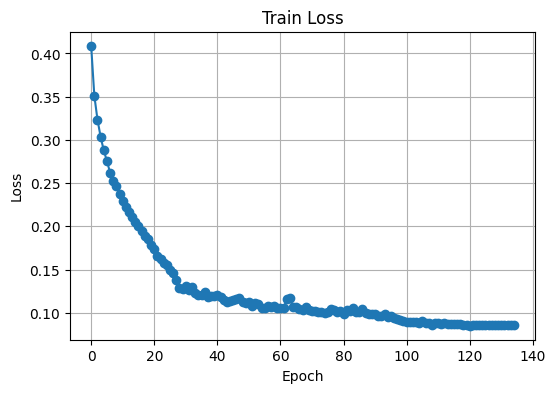

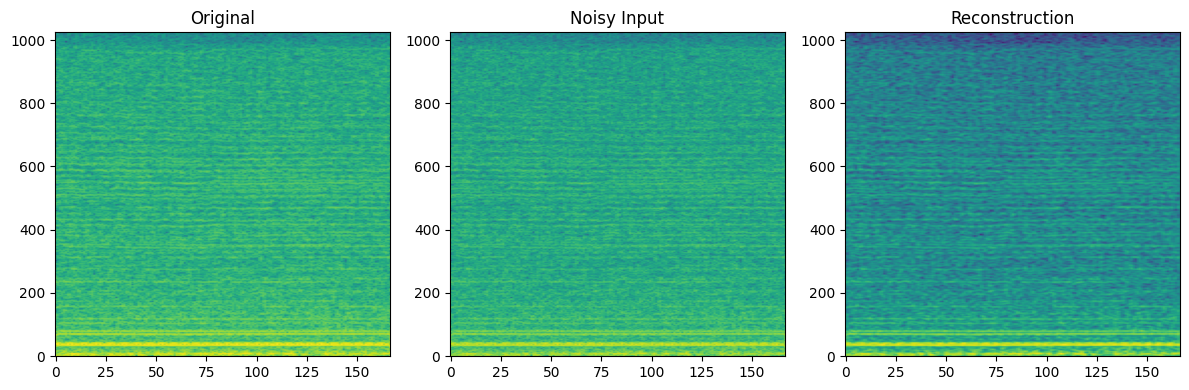

Epoch 136/200: 100%|██████████| 169/169 [01:12<00:00,  2.32it/s]


[Epoch 136] No improvement: loss 0.0853, patience 15/15
Early stopping triggered.


Eval:   0%|          | 0/1080 [00:00<?, ?it/s]


AssertionError: Expected values to be greater or equal to 0, got -2.6589272022247314

In [61]:
if __name__ == "__main__":
    args = get_args()
    set_seed(2025)
    train_and_evaluate(args)